In [50]:
!pip install -U hopsworks --quiet

#Importing necessary liabraries

In [51]:
import requests
import json
import pandas as pd
import numpy as np

https://aqicn.org/api/
https://aqicn.org/json-api/doc/

#Data Preparation


The dataset is downloaded from aqicn.org. I choose the loaction mandir-marg, delhi
Here I am doing aqi_prediction on this location only.


This data is required for backfilling the features

In [52]:
csv_file_path = '/content/mandir-marg, delhi-air-quality.csv'

data = pd.read_csv(csv_file_path)

data.head(-10)


,date,pm25,pm10,o3,no2,so2,co
0,2023/7/1,41,51,20,18,8,7
1,2023/7/2,52,101,24,19,4,8
2,2023/7/3,146,81,19,25,6,8
3,2023/7/4,119,65,21,22,6,8
4,2023/7/5,100,50,19,22,4,7
...,...,...,...,...,...,...,...
3365,2014/8/28,,64,19,40,6,6
3366,2014/8/29,,78,4,45,50,11
3367,2014/8/31,,54,54,34,5,4
3368,2014/9/13,,82,29,30,5,4


There were leading spaces in the labels of the columns. The below code removes these spaces

In [53]:
data.columns = data.columns.str.strip()
data.columns

Index(['date', 'pm25', 'pm10', 'o3', 'no2', 'so2', 'co'], dtype='object')

Below code removes the rows with empty values. The empty strings were replaced with NAN values and the rows with NAN values were dropped

In [54]:
data = data.replace(' ', pd.NA).dropna()

data = data.reset_index(drop=True)

print(data.head(-10))

           date  pm25  pm10   o3  no2 so2   co
0      2023/7/1    41    51   20   18   8    7
1      2023/7/2    52   101   24   19   4    8
2      2023/7/3   146    81   19   25   6    8
3      2023/7/4   119    65   21   22   6    8
4      2023/7/5   100    50   19   22   4    7
...         ...   ...   ...  ...  ...  ..  ...
3071  2014/3/17   183    89   28   14   5    3
3072  2014/3/18   112    81   44   16   5    3
3073  2014/3/19   116    92   48   22   5    5
3074  2014/3/20   138   138   45   42   8    9
3075  2014/3/21   168   127   40   33   6   10

[3076 rows x 7 columns]


In the dataset we get the following six columns:

['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']

So we need to calculate overall AQI. Below code calculates overall AQI

In [55]:
def calculate_overall_aqi(row):
    concentrations = row[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']].astype(float)
    c = max(concentrations)
    breakpoints = [
        (0.0, 50.0), (51.0, 100.0), (101.0, 150.0), (151.0, 200.0),
        (201.0, 300.0), (301.0, 400.0), (401.0, 500.0)
    ]
    ilow, ihigh = 0, 0

    for cl, ch in breakpoints:
        if cl <= c <= ch:
            ilow, ihigh = breakpoints.index((cl, ch)) * 50, (breakpoints.index((cl, ch)) + 1) * 50
            break

    aqi = ((ihigh - ilow) / (ch - cl)) * (c - cl) + ilow
    return round(aqi)


In [56]:
data['aqi'] = data.apply(calculate_overall_aqi, axis=1)
data.head()

,date,pm25,pm10,o3,no2,so2,co,aqi
0,2023/7/1,41,51,20,18,8,7,50
1,2023/7/2,52,101,24,19,4,8,100
2,2023/7/3,146,81,19,25,6,8,146
3,2023/7/4,119,65,21,22,6,8,118
4,2023/7/5,100,50,19,22,4,7,100


Here I am retriving new data from aqicn.org api for mandir-mard, Delhi location. It updates every 1 hour.

In [57]:
results = requests.get("https://api.waqi.info/feed/delhi/mandir-marg/?token=4a95eecaa38924fb067d8e35a491ac2d386b0d64")
api_data = results.json()['data']
api_data

{'aqi': 87,
 'idx': 2554,
 'attributions': [{'url': 'http://dpccairdata.com/',
   'name': 'Delhi Pollution Control Commitee (Government of NCT of Delhi)',
   'logo': 'India-DPCCC.png'},
  {'url': 'http://cpcb.nic.in/',
   'name': 'CPCB - India Central Pollution Control Board',
   'logo': 'India-CPCB.png'},
  {'url': 'https://waqi.info/', 'name': 'World Air Quality Index Project'}],
 'city': {'geo': [28.6341, 77.2005],
  'name': 'Mandir Marg, Delhi, Delhi, India',
  'url': 'https://aqicn.org/city/delhi/mandir-marg',
  'location': ''},
 'dominentpol': 'pm25',
 'iaqi': {'co': {'v': 7.3},
  'dew': {'v': 27},
  'h': {'v': 114.05},
  'no2': {'v': 20.8},
  'o3': {'v': 8.9},
  'p': {'v': 979.05},
  'pm10': {'v': 49},
  'pm25': {'v': 87},
  'so2': {'v': 3.6},
  't': {'v': 26.25},
  'w': {'v': 0.55},
  'wd': {'v': 66.8},
  'wg': {'v': 8.2}},
 'time': {'s': '2023-07-13 00:00:00',
  'tz': '+05:30',
  'v': 1689206400,
  'iso': '2023-07-13T00:00:00+05:30'},
 'forecast': {'daily': {'o3': [{'avg': 5,


In [58]:
values = [api_data['iaqi'][param]['v'] for param in ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']]
values.append(api_data['aqi'])

print(values)

[87, 49, 8.9, 20.8, 3.6, 7.3, 87]


In [59]:
date = api_data['time']['s'].split()[0]
date = api_data['time']['s'].split()[0].replace('-', '/')
values.insert(0, date)
values

['2023/07/13', 87, 49, 8.9, 20.8, 3.6, 7.3, 87]

In [60]:
new_row = pd.DataFrame([values], columns=data.columns)
data = pd.concat([new_row, data], ignore_index=True)

data.head(10)

,date,pm25,pm10,o3,no2,so2,co,aqi
0,2023/07/13,87,49,8.9,20.8,3.6,7.3,87
1,2023/7/1,41,51,20,18,8,7,50
2,2023/7/2,52,101,24,19,4,8,100
3,2023/7/3,146,81,19,25,6,8,146
4,2023/7/4,119,65,21,22,6,8,118
5,2023/7/5,100,50,19,22,4,7,100
6,2023/7/6,84,52,15,21,3,8,84
7,2023/4/1,104,73,89,24,2,9,103
8,2023/4/2,107,92,48,30,6,14,106
9,2023/4/3,138,67,43,48,3,8,138


In [61]:
columns_to_convert = data.columns.drop('date')

for column in columns_to_convert:
    data[column] = data[column].astype(int)

In [62]:
data['date'] = pd.to_datetime(data['date'])

In [63]:
data

,date,pm25,pm10,o3,no2,so2,co,aqi
0,2023-07-13,87,49,8,20,3,7,87
1,2023-07-01,41,51,20,18,8,7,50
2,2023-07-02,52,101,24,19,4,8,100
3,2023-07-03,146,81,19,25,6,8,146
4,2023-07-04,119,65,21,22,6,8,118
...,...,...,...,...,...,...,...,...
3082,2014-03-27,151,104,12,31,5,10,150
3083,2014-03-28,160,91,21,18,4,5,159
3084,2014-03-29,149,79,42,16,7,3,149
3085,2014-03-30,115,94,55,16,6,4,114


#Data exploration


Checking for null values

In [64]:
data.isnull().sum()

date    0
pm25    0
pm10    0
o3      0
no2     0
so2     0
co      0
aqi     0
dtype: int64

Checking for duplicate values

In [65]:
duplicates = data.duplicated()

num_duplicates = duplicates.sum()

print(f"Number of duplicates: {num_duplicates}")

Number of duplicates: 0


In [66]:
data.describe()

,pm25,pm10,o3,no2,so2,co,aqi
count,3087.000000,3087.000000,3087.000000,3087.000000,3087.000000,3087.000000,3087.000000
mean,167.890833,125.560739,23.587626,26.761257,6.135730,10.342728,160.759313
std,76.065046,73.453294,21.232305,14.073009,4.220745,6.727532,58.587312
min,31.000000,15.000000,1.000000,3.000000,1.000000,1.000000,0.000000
25%,119.000000,77.000000,9.000000,18.000000,3.000000,6.000000,120.000000
50%,157.000000,110.000000,18.000000,24.000000,5.000000,8.000000,158.000000
75%,200.000000,152.000000,30.000000,33.000000,8.000000,13.000000,203.000000
max,999.000000,819.000000,185.000000,116.000000,65.000000,64.000000,349.000000


Here we can see that there is a big difference between mean and std of some column. So we can conclude that outliers are present in our dataset

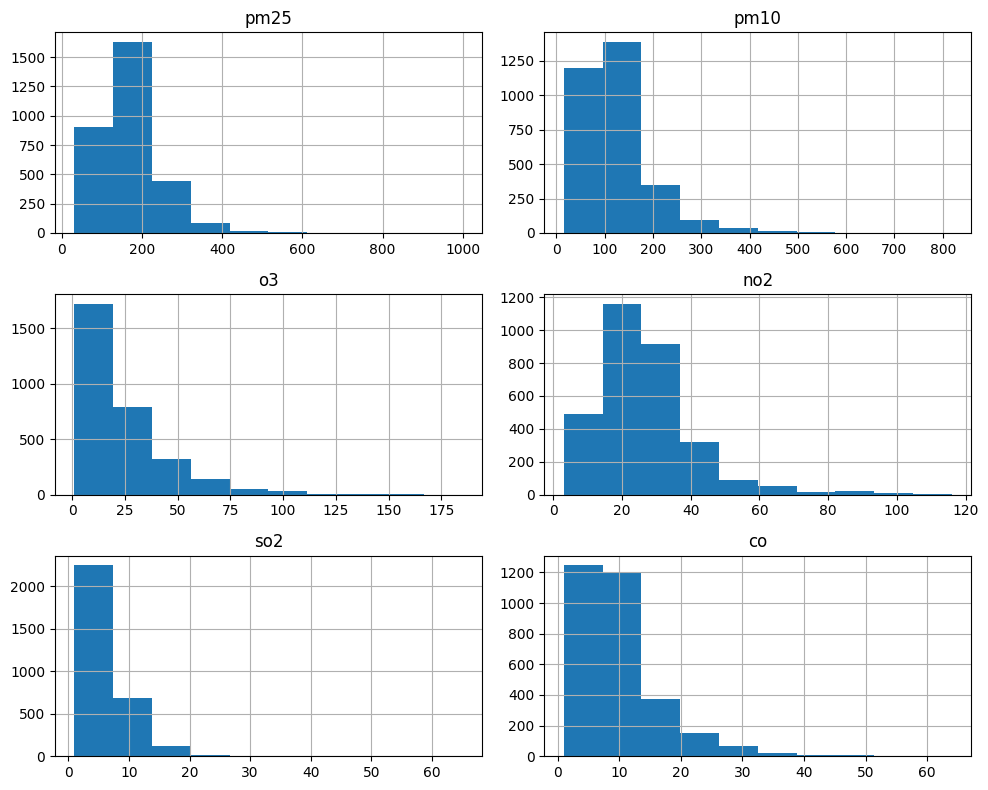

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

data[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


Here we can see that most of the plots are left skewed which is normal for unprocessed data. Here long tails indicate that outliers are present

Plotting box plot

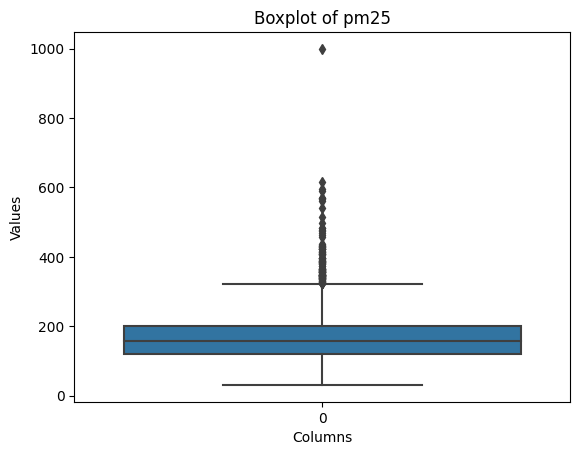

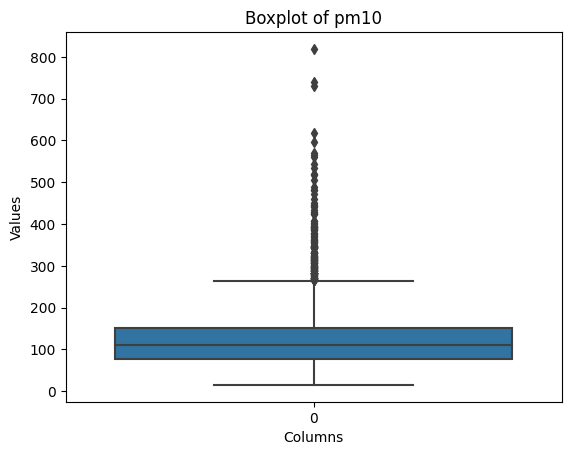

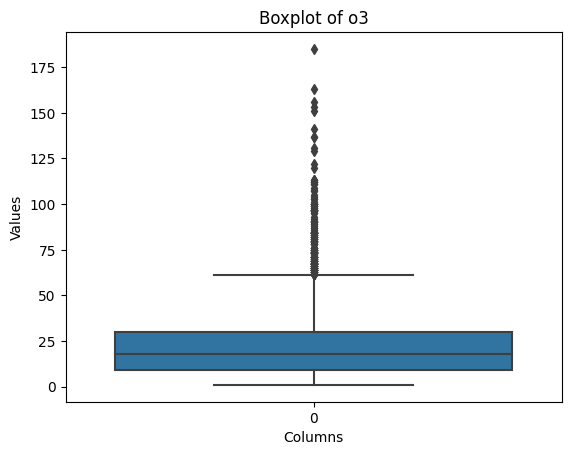

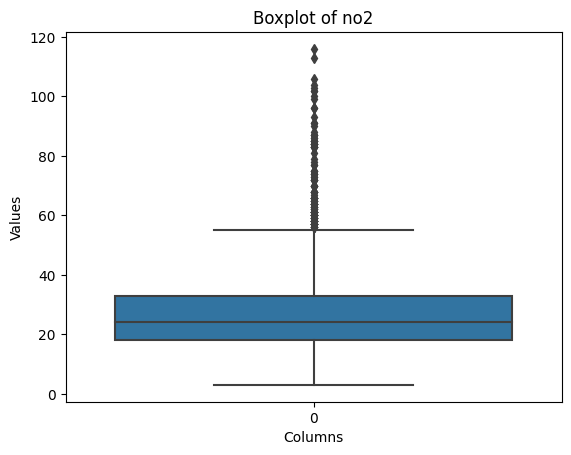

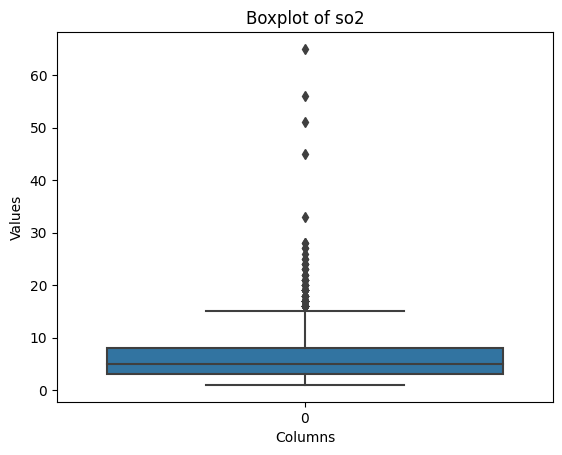

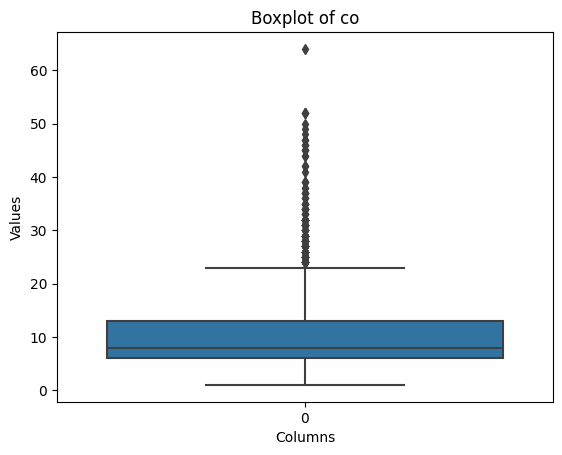

In [68]:
import pandas as pd
import seaborn as sns

# Assuming 'data' is your dataframe
selected_columns = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']  # Replace with your desired column names

# Create a new dataframe with the selected columns
selected_data = data[selected_columns]

# Create individual boxplots using seaborn
for column in selected_data.columns:
    plt.figure()  # Create a new figure for each boxplot
    sns.boxplot(data=selected_data[column])

    # Set the title and labels for the plot
    plt.title(f'Boxplot of {column}')
    plt.xlabel('Columns')
    plt.ylabel('Values')

# Show the plots
plt.show()



Below code removes outliers

In [69]:
Q1 = data.drop(['date'], axis=1).quantile(0.25)
Q3 = data.drop(['date'], axis=1).quantile(0.75)
IQR = Q3 - Q1

outliers = ((data.drop(['date'], axis=1) < (Q1 - 1.5 * IQR)) | (data.drop(['date'], axis=1) > (Q3 + 1.5 * IQR)))

data = data[~outliers.any(axis=1)]

num_outliers_removed = outliers.any(axis=1).sum()
print(f"Number of outliers removed: {num_outliers_removed}")
data

Number of outliers removed: 626


,date,pm25,pm10,o3,no2,so2,co,aqi
0,2023-07-13,87,49,8,20,3,7,87
1,2023-07-01,41,51,20,18,8,7,50
2,2023-07-02,52,101,24,19,4,8,100
3,2023-07-03,146,81,19,25,6,8,146
4,2023-07-04,119,65,21,22,6,8,118
...,...,...,...,...,...,...,...,...
3081,2014-03-26,168,101,31,28,8,6,167
3082,2014-03-27,151,104,12,31,5,10,150
3083,2014-03-28,160,91,21,18,4,5,159
3084,2014-03-29,149,79,42,16,7,3,149


In [70]:
data.reset_index(drop=True, inplace=True)

In [71]:
data=data.reset_index()

In [72]:
data

,index,date,pm25,pm10,o3,no2,so2,co,aqi
0,0,2023-07-13,87,49,8,20,3,7,87
1,1,2023-07-01,41,51,20,18,8,7,50
2,2,2023-07-02,52,101,24,19,4,8,100
3,3,2023-07-03,146,81,19,25,6,8,146
4,4,2023-07-04,119,65,21,22,6,8,118
...,...,...,...,...,...,...,...,...,...
2456,2456,2014-03-26,168,101,31,28,8,6,167
2457,2457,2014-03-27,151,104,12,31,5,10,150
2458,2458,2014-03-28,160,91,21,18,4,5,159
2459,2459,2014-03-29,149,79,42,16,7,3,149


In above data I have added an extra column index. Because while passing the data to feature store I need to pass primary key. We can use this index column as primary key

Below code plots the pairplot

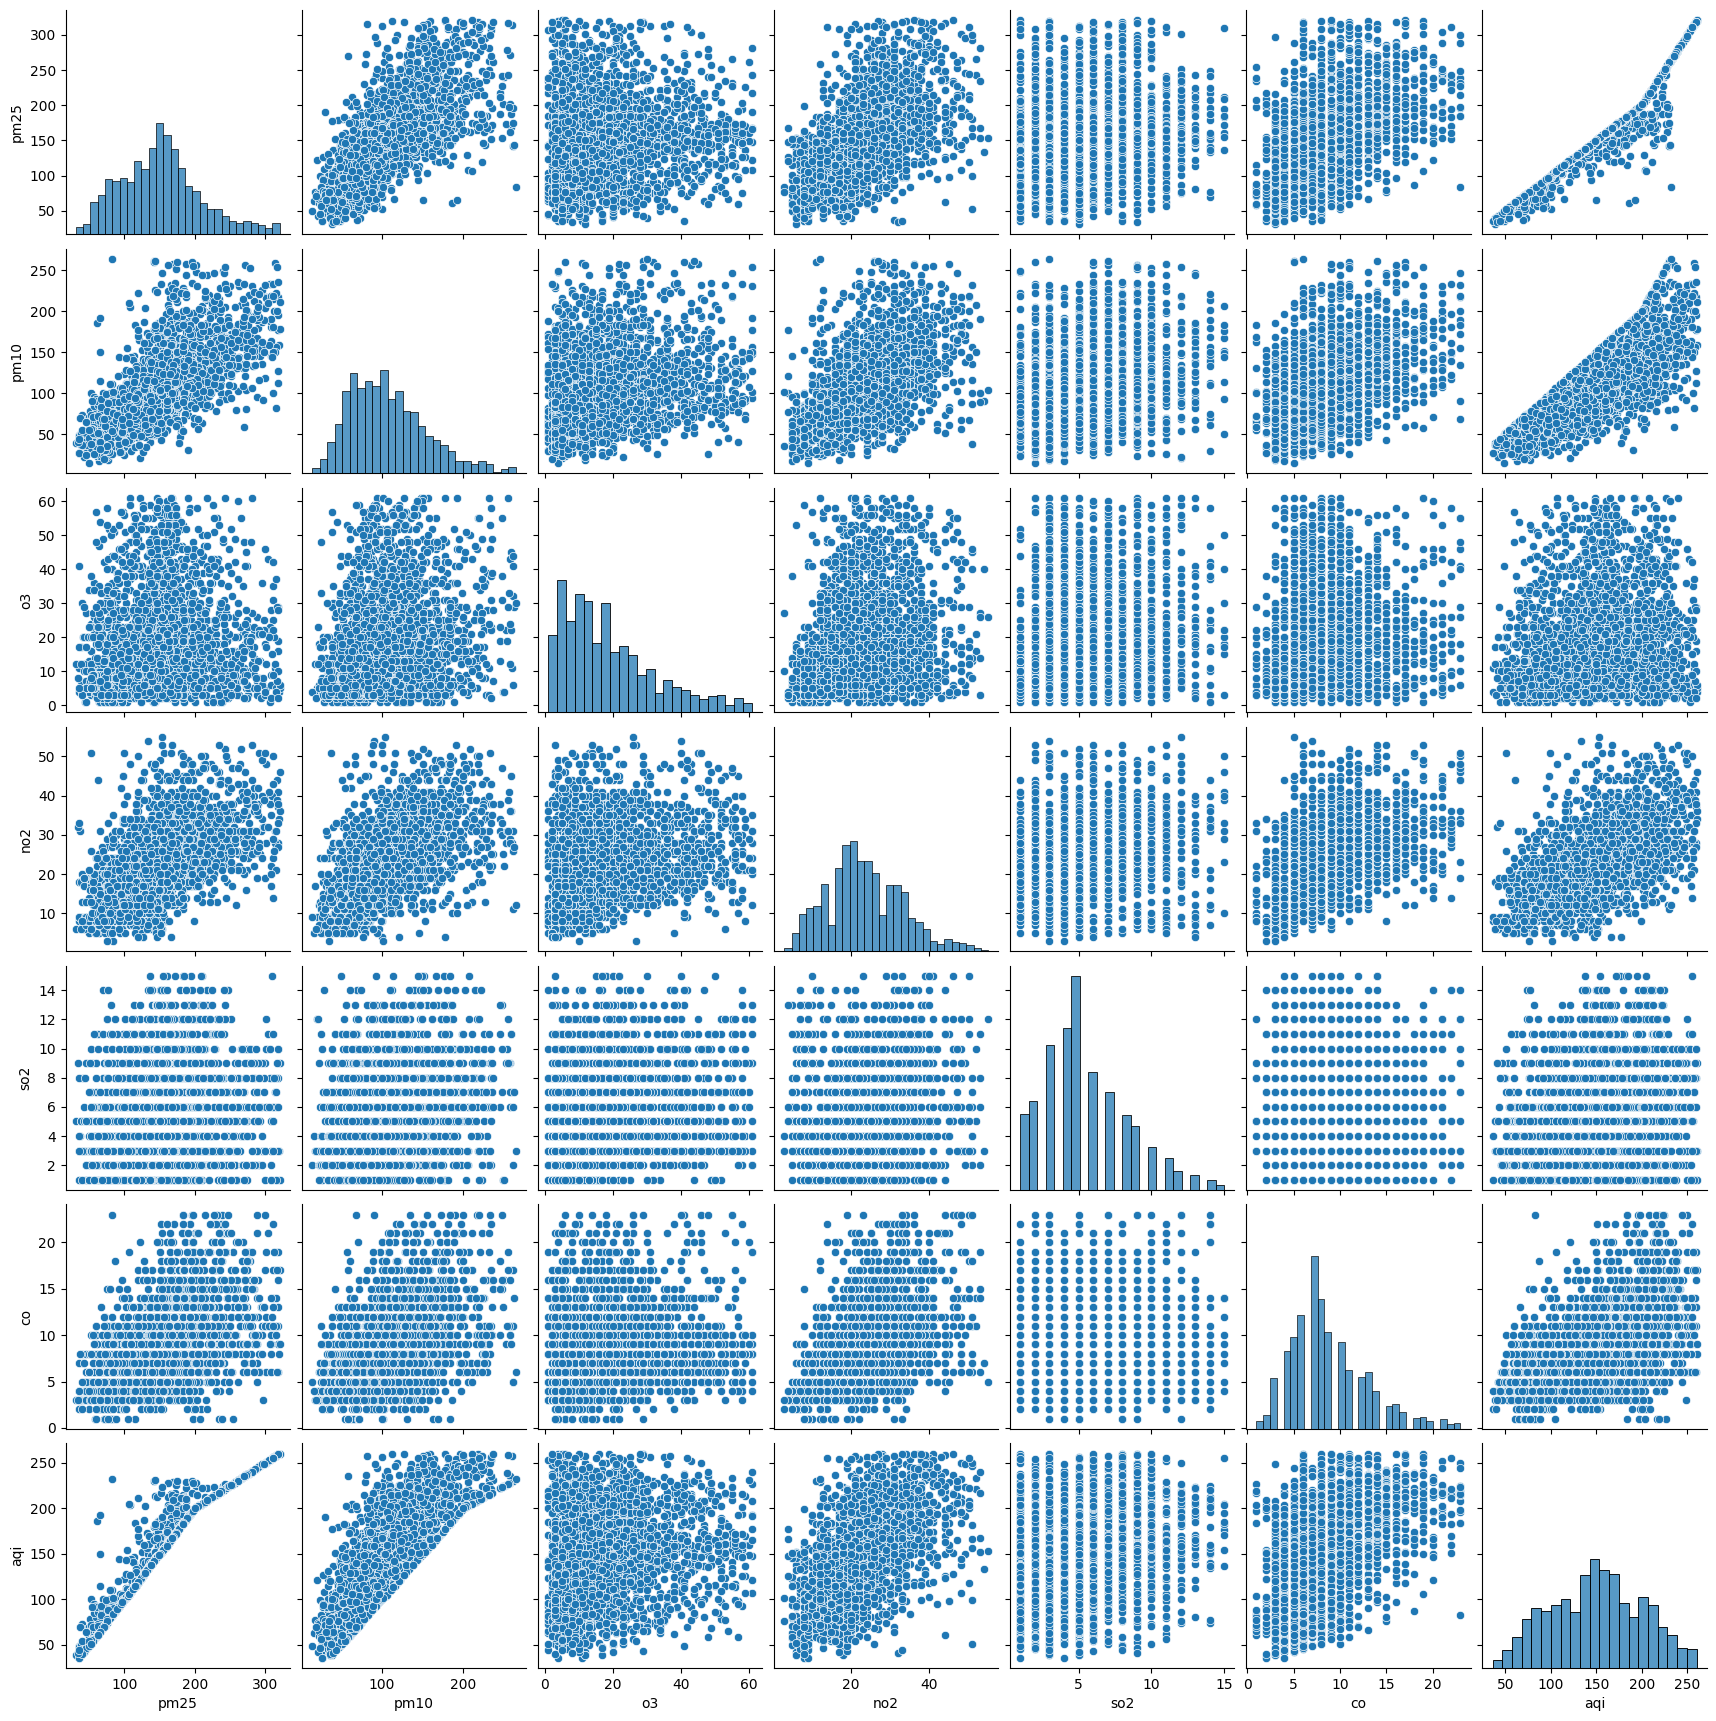

In [73]:
import seaborn as sns

columns = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'aqi']

sns.pairplot(data[columns])

plt.show()

Here we can see that with increse in values of feature columns the value of aqi also increases. So we can say that aqi have dependencies on these features have dependencies

#Adding data to hopsworks feature store

Connecting to hopsworks...

In [63]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/72855
Connected. Call `.close()` to terminate connection gracefully.


Below code creates the feature group

In [64]:
data_fg = fs.get_or_create_feature_group(
    name="aqi_prediction",
    version=1,
    description="Transaction data",
    primary_key=["index"]
)

In [65]:
data_fg.insert(data, write_options={"wait_for_job": False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/72855/fs/72774/fg/77256


Uploading Dataframe: 0.00% |          | Rows 0/2461 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aqi_prediction_1_offline_fg_backfill
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/72855/jobs/named/aqi_prediction_1_offline_fg_backfill/executions


(<hsfs.core.job.Job at 0x7f440fef1c30>, None)

Here I have inserted the data to feature group

In [66]:
feature_descriptions = [
    {"name": "index", "description": "This column is the index of the dataframe, which uniquely identifies each row. It helps to access and reference specific rows in the dataframe."},
    {"name": "date", "description": "This column represents the date of the data entry. It typically stores information in a date format, allowing for temporal analysis."},
    {"name": "pm25", "description": " This feature represents the concentration of particulate matter with a diameter of 2.5 micrometers or smaller (PM2.5) in the air. It is a measure of air pollution and is often used to assess air quality."},
    {"name": "pm10", "description": "This feature represents the concentration of particulate matter with a diameter of 10 micrometers or smaller (PM10) in the air. Like PM2.5, it is also used as an indicator of air pollution."},
    {"name": "o3", "description": "This feature represents the concentration of ozone (O3) in the air. Ozone is a gas that forms in the atmosphere and can be both beneficial and harmful, depending on its concentration."},
    {"name": "no2", "description": "This feature represents the concentration of nitrogen dioxide (NO2) in the air. NO2 is a harmful gas produced by burning fossil fuels and is associated with respiratory problems and air pollution."},
    {"name": "so2", "description": "This feature represents the concentration of sulfur dioxide (SO2) in the air. SO2 is a gas released during the combustion of fossil fuels and is a major contributor to air pollution and acid rain."},
    {"name": "co", "description": "This feature represents the concentration of carbon monoxide (CO) in the air. CO is a colorless and odorless gas produced by the incomplete burning of carbon-containing fuels. High levels of CO can be harmful to human health."},
    {"name": "aqi", "description": "AQI is the Air Quality Index, a measure used to report air quality levels and associated health risks. It's calculated based on pollutant concentrations such as PM2.5, PM10, O3, NO2, SO2, and CO."},
]

for desc in feature_descriptions:
    data_fg.update_feature_description(desc["name"], desc["description"])

The above code add descriptions to the columns in the feature group

#Model Building

Here I am doing a comparitive study of some models

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.neighbors import KNeighborsRegressor

X = data.drop(['date', 'aqi'], axis=1)
y = data['aqi']

models = [
    ('SVM', SVR()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Random Forest', RandomForestRegressor()),
    ('XGBoost', XGBRegressor()),
    ('ANN', MLPRegressor()),
    ('LSTM', Sequential([LSTM(1, input_shape=(X.shape[1], 1))])),  # Example LSTM model, adjust parameters accordingly
    ('KNN', KNeighborsRegressor()),
]

best_model = None
best_r2_score = -float('inf')

for model_name, model in models:
    train_losses = []
    val_losses = []
    train_r2_scores = []
    val_r2_scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        if model_name == 'LSTM':
            X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

            model.compile(optimizer='adam', loss='mean_squared_error')

            model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, verbose=0)
        else:
            model.fit(X_train, y_train)

        if model_name == 'LSTM':
            X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

            y_train_pred = model.predict(X_train_reshaped)
        else:
            y_train_pred = model.predict(X_train)

        if model_name == 'LSTM':
            X_val_reshaped = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

            y_val_pred = model.predict(X_val_reshaped)
        else:
            y_val_pred = model.predict(X_val)

        train_loss = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        val_loss = mean_squared_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2_scores.append(train_r2)
        val_r2_scores.append(val_r2)

    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_r2 = np.mean(train_r2_scores)
    mean_val_r2 = np.mean(val_r2_scores)

    print(f"Model: {model_name}")
    print(f"Mean Training MSE: {mean_train_loss}")
    print(f"Mean Validation MSE: {mean_val_loss}")
    print(f"Mean Training R^2 Score: {mean_train_r2}")
    print(f"Mean Validation R^2 Score: {mean_val_r2}")

    if mean_val_r2 > best_r2_score:
        best_model = model_name
        best_r2_score = mean_val_r2

print(f"\nBest Model: {best_model}")


Model: SVM
Mean Training MSE: 1994.4774409701192
Mean Validation MSE: 2001.693342698
Mean Training R^2 Score: 0.20426042346351272
Mean Validation R^2 Score: 0.19719335526042922
Model: Decision Tree
Mean Training MSE: 0.0
Mean Validation MSE: 13.580167878757894
Mean Training R^2 Score: 1.0
Mean Validation R^2 Score: 0.9945644717368367
Model: Random Forest
Mean Training MSE: 1.496084722507814
Mean Validation MSE: 8.631658939873681
Mean Training R^2 Score: 0.9994028661046823
Mean Validation R^2 Score: 0.9965237557453788
Model: XGBoost
Mean Training MSE: 0.045476864652510184
Mean Validation MSE: 3.623730816231551
Mean Training R^2 Score: 0.9999818629860379
Mean Validation R^2 Score: 0.9985457544542389


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model: ANN
Mean Training MSE: 59.75326835191477
Mean Validation MSE: 63.08293253973609
Mean Training R^2 Score: 0.9761827931596955
Mean Validation R^2 Score: 0.9747289960177478
16/16 [==============================] - 0s 2ms/step
Model: LSTM
Mean Training MSE: 24631.704659750238
Mean Validation MSE: 24631.16686600955
Mean Training R^2 Score: -8.827418272170195
Mean Validation R^2 Score: -8.878272306494518
Model: KNN
Mean Training MSE: 45.149373779352324
Mean Validation MSE: 73.55310981381619
Mean Training R^2 Score: 0.9819861198067121
Mean Validation R^2 Score: 0.9704405321926407

Best Model: XGBoost


Heere we can see that XGBoost is performing best in our case

So I will continue training with XGBoost

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(['date', 'aqi', 'index'], axis=1)
y = data['aqi']

model = XGBRegressor()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_loss = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_loss = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)
mean_train_r2 = np.mean(train_r2_scores)
mean_val_r2 = np.mean(val_r2_scores)

print(f"Mean Training MSE: {mean_train_loss}")
print(f"Mean Validation MSE: {mean_val_loss}")
print(f"Mean Training R^2 Score: {mean_train_r2}")
print(f"Mean Validation R^2 Score: {mean_val_r2}")

Mean Training MSE: 0.04273034143224476
Mean Validation MSE: 3.447731584598235
Mean Training R^2 Score: 0.9999829478536484
Mean Validation R^2 Score: 0.9986174134120624


Here we can see the data is slightly overfitted. So I will apply l2 regularizaton and also do hyperparameter tuning. For hyperparameter tuning I will use optuna library to choose the best hyperparameters

In [78]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 1.0)
    }

    X = data.drop(['date', 'aqi', 'index'], axis=1)
    y = data['aqi']

    train_losses = []
    val_losses = []
    train_r2_scores = []
    val_r2_scores = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = XGBRegressor(**params)

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        train_loss = mean_squared_error(y_train, y_train_pred)
        train_r2 = r2_score(y_train, y_train_pred)

        val_loss = mean_squared_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2_scores.append(train_r2)
        val_r2_scores.append(val_r2)

    mean_val_loss = np.mean(val_losses)
    mean_val_r2 = np.mean(val_r2_scores)

    return mean_val_loss

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=100)

best_params = study.best_params
best_value = study.best_value

print("Best Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print("Best Value:", best_value)


[I 2023-07-12 19:09:17,764] A new study created in memory with name: no-name-dc07b4d6-5f7b-4c7f-9e32-c1637406d721
[I 2023-07-12 19:09:19,614] Trial 0 finished with value: 4.233750098532516 and parameters: {'n_estimators': 237, 'max_depth': 6, 'learning_rate': 0.05689998417307792, 'reg_lambda': 0.69417471041557}. Best is trial 0 with value: 4.233750098532516.
[I 2023-07-12 19:09:26,517] Trial 1 finished with value: 3.8167668776240595 and parameters: {'n_estimators': 958, 'max_depth': 5, 'learning_rate': 0.07391517091520497, 'reg_lambda': 0.6527713624243812}. Best is trial 1 with value: 3.8167668776240595.
[I 2023-07-12 19:09:52,578] Trial 2 finished with value: 2.2042880637967306 and parameters: {'n_estimators': 794, 'max_depth': 3, 'learning_rate': 0.03893056077675617, 'reg_lambda': 0.3091711869197633}. Best is trial 2 with value: 2.2042880637967306.
[I 2023-07-12 19:10:11,890] Trial 3 finished with value: 3.031839278642694 and parameters: {'n_estimators': 544, 'max_depth': 4, 'learnin

Best Hyperparameters:
n_estimators: 1000
max_depth: 3
learning_rate: 0.09589363456887201
reg_lambda: 0.1985672595220302
Best Value: 1.725108733434272


In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(['date', 'aqi', 'index'], axis=1)
y = data['aqi']

best_params = {
    'n_estimators': 1000,
    'max_depth': 3,
    'learning_rate': 0.09589363456887201,
    'reg_lambda': 0.1985672595220302
}

model = XGBRegressor(**best_params)

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_loss = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    val_loss = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_r2_scores.append(train_r2)
    val_r2_scores.append(val_r2)

mean_train_loss = np.mean(train_losses)
mean_val_loss = np.mean(val_losses)
mean_train_r2 = np.mean(train_r2_scores)
mean_val_r2 = np.mean(val_r2_scores)

print(f"Mean Training MSE: {mean_train_loss}")
print(f"Mean Validation MSE: {mean_val_loss}")
print(f"Mean Training R^2 Score: {mean_train_r2}")
print(f"Mean Validation R^2 Score: {mean_val_r2}")


Mean Training MSE: 0.1014059372412166
Mean Validation MSE: 1.725108733434272
Mean Training R^2 Score: 0.9999595779904569
Mean Validation R^2 Score: 0.9993070658364012


In [86]:
new_data = np.array([[123.0, 50.0, 4.2, 18.4, 40.5, 15.2]])
predicted_aqi = model.predict(new_data)
print(predicted_aqi)

[122.40939]


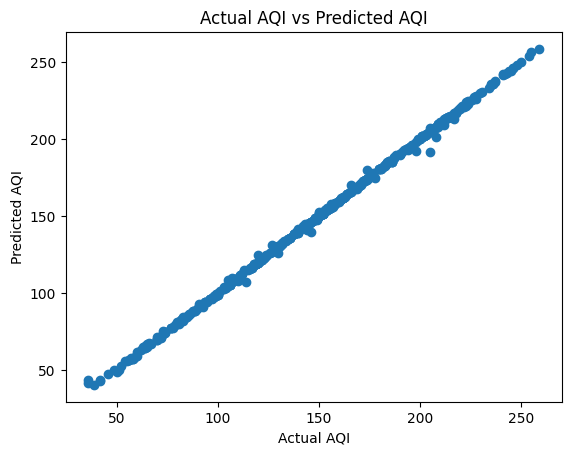

In [87]:
y_test_pred = model.predict(X_val)

plt.scatter(y_val, y_val_pred)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual AQI vs Predicted AQI')
plt.show()

#Adding model to hopsworks model registry

Connecting to hopsworks...

In [99]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/72855
Connected. Call `.close()` to terminate connection gracefully.


Getting the feature group

In [100]:
data = fs.get_feature_group('aqi_prediction', version=1)
data

Selecting features to train the model with

In [101]:
query = data.select(["pm25", "pm10", "o3", "no2", "so2", "co", "aqi"])

In [102]:
query.show(5)

,pm25,pm10,o3,no2,so2,co,aqi
0,71,41,7,8,4,3,70
1,50,29,13,5,3,5,50
2,213,184,27,23,10,8,206
3,189,88,3,21,7,5,189
4,53,56,5,13,6,4,55


Creating feature view

In [103]:
feature_view = fs.get_or_create_feature_view(
    name='aqi_prediction_fv',
    version=1,
    query=query,
    labels=["aqi"]
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/72855/fs/72774/fv/aqi_prediction_fv/version/1


In [104]:
TEST_SIZE = 0.25

td_version, td_job = feature_view.create_train_test_split(
    description = 'pollution dataset',
    data_format = 'csv',
    test_size = TEST_SIZE,
    write_options = {'wait_for_job': True}
)


Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/72855/jobs/named/aqi_prediction_fv_1_create_fv_td_12072023082845/executions


In [105]:
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(td_version)

Training the model

In [106]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

In [112]:
losses = []
r2_scores = []

model = XGBRegressor(
    n_estimators = 1000,
    max_depth = 3,
    learning_rate = 0.09589363456887201,
    reg_lambda = 0.1985672595220302
)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)


Creating model schema

In [113]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train.values)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'tensor_schema': {'shape': '(1822, 6)', 'type': 'int64'}},
 'output_schema': {'columnar_schema': [{'name': 'aqi', 'type': 'int64'}]}}

Connecting to model registry and exporting the model

In [114]:
import os
import joblib

model_dir="aqi_prediction_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

joblib.dump(model, model_dir + '/xgboost_aqi_prediction_model.pkl')

['aqi_prediction_model/xgboost_aqi_prediction_model.pkl']

In [115]:
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [116]:

aqi_prediction_model = mr.python.create_model(
    name="aqi_prediction_model",
    model_schema=model_schema,
    input_example=X_train.sample(),
    description="AQI predictor")

aqi_prediction_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/72855/models/aqi_prediction_model/1


Model(name: 'aqi_prediction_model', version: 1)